In [1]:
from spatialmath import *
import matplotlib.pyplot as plt

# Basic pure rotation/translation visualization

1. A rotation about the Z-axis (e.g., a 90-degree rotation), which could represent the orientation of a camera or robot arm in the plane.
2. A translation along the X-axis, which could simulate moving an object or camera in space.

<Figure size 640x480 with 0 Axes>

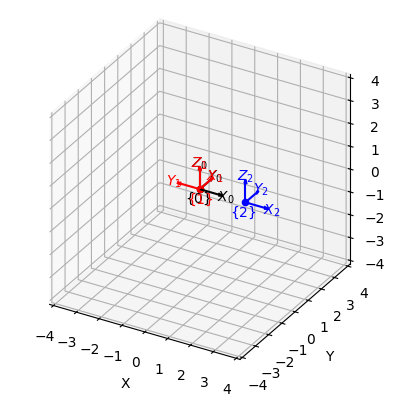

In [2]:
# 0. Identity transformation used as base frame
base = SE3()

# 1. Rotation about Z-axis by 90 degrees
rot_z_90 = SE3.Rz(90, unit='deg')

# 2. Translation along X-axis by 2 unit
trans_x_2 = SE3.Tx(2)

plt.figure()
base.plot(frame='0', color='black', dims=[-4, 4])
rot_z_90.plot(frame='1', color='red')
trans_x_2.plot(frame='2', color='blue')

Given frame 0 (black) as the world frame (the 3 axis follow the right-hand rule where the thumb points to the z-axis, the index finger points to the x-axis, and the middle finger points to the y-axis), we can visualize the following:
- Frame 1 (red) is rotated 90 degrees about the Z-axis (the rotation direction can be figured out by the right-hand rule where the thumb points in the direction of the axis and the fingers curl in the direction of the rotation)
- Frame 2 (blue) is translated 2 unit along the X-axix (the direction is towards the X-axis shown)

# Combined single rotation and translation visualization

Compose the previous two transformations to visualize a combined rotation and translation, or vice versa. Note that the order of the transformations matters.

1. A combined rotation and translation, representing an object that has been rotated and then moved.
2. A combined translation and rotation, representing an object that has been moved and then rotated. 

<Figure size 640x480 with 0 Axes>

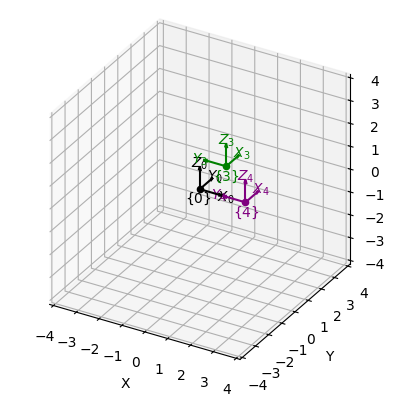

In [3]:
# 3. Rotation about Z-axis by 90 degrees followed by translation along X-axis by 2 unit
rot_z_90_then_trans_x_2 = rot_z_90 * trans_x_2

# 4. Translation along X-axis by 2 unit followed by rotation about Z-axis by 90 degrees
trans_x_2_then_rot_z_90 = trans_x_2 * rot_z_90

plt.figure()
base.plot(frame='0', color='black', dims=[-4, 4])
rot_z_90_then_trans_x_2.plot(frame='3', color='green')
trans_x_2_then_rot_z_90.plot(frame='4', color='purple')

Given frame 0 (black) as the world frame, we can visualize the following:
- Frame 3 (green) is rotated 90 degrees about the Z-axis, so its X-axis is aligned with the world frame's Y-axis. Therefore, the subsequent translation along the X-axis will be along the world frame's Y-axis.
- Frame 4 (purple) is translated 2 unit along the X-axis, which still aligns with the world frame's X-axis. And then it is rotated 90 degrees about the Z-axis, so its X-axis is now pointing in the same direction as the world frame's Y-axis.

Notice that if we apply frame 4 transformation 4 times, it will go back to same orientation and position as the initial frame 0. This could present a loop in a robot's movement or a camera's scanning in a 2D plane.

<Figure size 640x480 with 0 Axes>

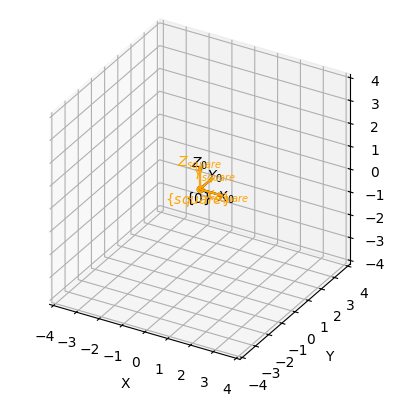

In [4]:
# Applying the same transformation 4 times
square_transformation = trans_x_2_then_rot_z_90 ** 4

plt.figure()
base.plot(frame='0', color='black', dims=[-4, 4])
square_transformation.plot(frame='square', color='orange')

# Assert the 2 frames are equal
assert square_transformation == base

# Relation between transformation matrices

Suppose we want to find the transformation maxtrix from frame 3 to frame 4, we can use frame 0 as an intermediate step. Basically we have H<sub>03</sub> and H<sub>04</sub> and we want to find H<sub>34</sub>. We can use the following relation:

- H<sub>30</sub> = inv(H<sub>03</sub>) by taking the inverse property of SE(3) transformation matrices
- H<sub>34</sub> = H<sub>30</sub> * H<sub>04</sub> by subscript cancellation rule for SE(3) transformation matrices multiplication

Given the coordinates of any point p relative to frame 4, we can find its corresponding coordinates relative to frame 3 by p' = inv(H<sub>34</sub>) * p.

By observing the visualization above, we should expect H_34 to be a translation along the world frame's X-axis by -2 units and along the world frame's Y-axis by -2 units.

<Figure size 640x480 with 0 Axes>

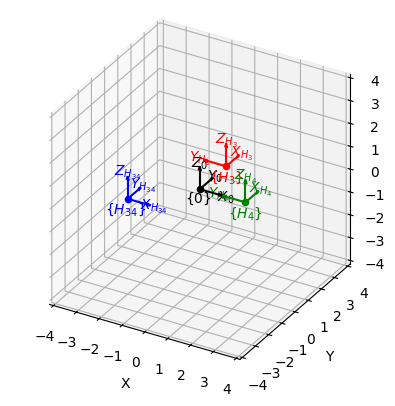

In [5]:
H_03 = rot_z_90_then_trans_x_2
H_04 = trans_x_2_then_rot_z_90

H_34 = H_03.inv() * H_04
H_34_expected = SE3.Tx(-2) * SE3.Ty(-2)

# Assert the 2 frames are equal
assert H_34 == H_34_expected

plt.figure()
base.plot(frame='0', color='black', dims=[-4, 4])
H_03.plot(frame='H_{3}', color='red')
H_04.plot(frame='H_{4}', color='green')
H_34.plot(frame='H_{34}', color='blue')

Given frame 0 (black) as the world frame, we can visualize the following:
- Frame H<sub>34</sub> (blue) is translated -2 unit along the X-axis and -2 unit along the Y-axis, which aligns with the transformation from frame H<sub>3</sub> to frame H<sub>4</sub> in the perspective of frame H<sub>3</sub>.

# Application

Based on my understanding, I try to re-explain the given article: https://medium.com/geekculture/the-following-article-describes-a-simple-approach-to-solving-a-common-problem-in-robotics-8276d0a6caee

Given 5 frames below:
- A: world frame 
- B: robot base frame
- C: robot hand frame
- D: camera frame
- E: object frame

We want to find the transformation matrix H<sub>CE</sub> so that the robot hand (a rigid body) knows the required translation and rotation to move from its current position to the object position. Note also that H<sub>EC</sub> is the inverse of H<sub>CE</sub>.

Note that we cannot just find H<sub>CE</sub> = H<sub>CA</sub> * H<sub>AE</sub> directly because we do not have these 2 matrices yet. Instead, we can find H<sub>CE</sub> using the following available matrices:

- H<sub>AB</sub> is known since the robot base is fixed and does not move, so it is a constant matrix that is known
- H<sub>BC</sub> is known since the robot hand as the robot constantly keeps track of the position and orientation of its hand relative to its base
- H<sub>AD</sub> is known since the camera is fixed and does not move, so it is a constant matrix that is known
- H<sub>DE</sub> is known since the camera can compute the position and orientation of the object relative to camera itself

Hence, we can find H<sub>CE</sub> as:

H<sub>CE</sub> = H<sub>CA</sub> * H<sub>AE</sub> = inv(H<sub>AC</sub>) * H<sub>AE</sub> = inv(H<sub>AB</sub> * H<sub>BC</sub>) * (H<sub>AD</sub> * H<sub>DE</sub>)